# Getting started with Amazon Braket Hybrid Jobs

This tutorial shows how to run your first Amazon Braket Hybrid Job. To get started, we consider a trivial algorithm and a small circuit with only one qubit and one gate.

This notebook to large parts follows the example `./Braket examples/hybrid_jobs/0_Creating_your_first_Hybrid_Job`. Further examples of more advanced features can be found in the directory `./Braket examples/hybrid_jobs`.

## Learning outcomes
* Write an algorithm script to run on Braket Jobs
* Understand how to run scripts or functions
* Create a job on Braket simulators or QPUs
* Monitoring the job state
* Save results from a job
* Running jobs with priority on QPUs
* Use local jobs to quickly test and debug scripts

## Toy Problem

Most potential candidates for quantum applications don't just run on a QPU. Instead, your workload likely shifts back and forth between a CPU/GPU and a QPU.

Let's assume a very simple toy problem to illustrate this:

<div class="alert alert-block alert-info">
    <b>How does the expectation value of the observable $Z$ change with the angle of an $X$ rotation?</b>
</div>

<div align="center">
    <img src="circuit.png" width="400" />
</div>

Obviously, this problem can be easily solved analytically. 

With $$\left|0\right> = \begin{pmatrix} 1 \\ 0 \end{pmatrix}$$ and $$R_x(\theta) = \begin{pmatrix} \cos{\frac{\theta}{2}} & -i \sin{\frac{\theta}{2}} \\ -i \sin{\frac{\theta}{2}} & \cos{\frac{\theta}{2}} \end{pmatrix}$$ the quantum state $\left|\psi\right>$ prepared by the circuit above results in $$ \left|\psi\right> = R_x(\theta) \left|0\right> = \begin{pmatrix} \cos{\frac{\theta}{2}} \\ -i \sin{\frac{\theta}{2}} \end{pmatrix} $$ With the Pauli-Z operator $$ Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix} $$ the expectation value is $$ \left<\psi|Z|\psi\right> = \left|\cos{\frac{\theta}{2}}\right|^2 - \left|-i \sin{\frac{\theta}{2}}\right|^2 = \cos^2{\frac{\theta}{2}} - \sin^2{\frac{\theta}{2}} = \cos{\theta} $$

### Algorithm

For the purpose of this tutorial, we sample the result with a **hybrid algorithm** which evaluates $\left<Z\right>$ iteratively for given values of $\theta$. The classical part of the algorithm loops over the sequence of angles and updates the circuit parameter while the quantum part performs the measurement of the expecation value.

Let's review how we can code up the algorithm for this problem:

In [21]:
from braket.circuits import Circuit, FreeParameter, Observable
from braket.jobs.metrics import log_metric

import math


def run_algorithm(device, n_iterations, step_size, n_shots):
    # Let's define our quantum circuit
    example_circuit = Circuit().rx(0, FreeParameter("theta"))
    example_circuit.expectation(observable=Observable.Z(), target=0)
    print("Quantum circuit:")
    print(example_circuit)

    # Here, our actual algorithm starts:
    results = {}
    for idx in range(n_iterations):
        print(f">>> Iteration {idx}")
        rx_angle = math.pi * idx * step_size
        #rx_angle = math.pi * step_size
        result = device.run(
            example_circuit,
            shots=n_shots,
            inputs={"theta": rx_angle}
        ).result()
        exp_val = result.values[0]

        log_metric(metric_name="rotation_angle", value=rx_angle, iteration_number=idx)
        log_metric(metric_name="expectation_value", value=exp_val, iteration_number=idx)

        results[idx] = {
            'rx_angle': rx_angle,
            'expecation_value': exp_val
        }

    return results

Of crouse, the function `run_algorithm` can be executed locally. 

In [22]:
from braket.aws import AwsDevice
from braket.devices import Devices
from pprint import pprint

device = AwsDevice(Devices.Amazon.SV1)

results = run_algorithm(device, n_iterations=6, step_size=0.1, n_shots=100)

Quantum circuit:
T  : │      0      │   Result Types   │
      ┌───────────┐ ┌────────────────┐ 
q0 : ─┤ Rx(theta) ├─┤ Expectation(Z) ├─
      └───────────┘ └────────────────┘ 
T  : │      0      │   Result Types   │

Unassigned parameters: [theta].
>>> Iteration 0
Metrics - timestamp=1725168307.6941586; rotation_angle=0.0; iteration_number=0;
Metrics - timestamp=1725168307.6942425; expectation_value=1.0; iteration_number=0;
>>> Iteration 1
Metrics - timestamp=1725168310.4196935; rotation_angle=0.3141592653589793; iteration_number=1;
Metrics - timestamp=1725168310.419773; expectation_value=0.88; iteration_number=1;
>>> Iteration 2
Metrics - timestamp=1725168313.1347978; rotation_angle=0.6283185307179586; iteration_number=2;
Metrics - timestamp=1725168313.1348822; expectation_value=0.78; iteration_number=2;
>>> Iteration 3
Metrics - timestamp=1725168315.9404047; rotation_angle=0.9424777960769379; iteration_number=3;
Metrics - timestamp=1725168315.9404826; expectation_value=0.74; iterati

In [20]:
print(results)
pprint(results)

{0: {'rx_angle': 0.3141592653589793, 'expecation_value': 0.96}, 1: {'rx_angle': 0.3141592653589793, 'expecation_value': 0.98}, 2: {'rx_angle': 0.3141592653589793, 'expecation_value': 0.98}, 3: {'rx_angle': 0.3141592653589793, 'expecation_value': 0.94}, 4: {'rx_angle': 0.3141592653589793, 'expecation_value': 0.98}, 5: {'rx_angle': 0.3141592653589793, 'expecation_value': 0.94}}
{0: {'expecation_value': 0.96, 'rx_angle': 0.3141592653589793},
 1: {'expecation_value': 0.98, 'rx_angle': 0.3141592653589793},
 2: {'expecation_value': 0.98, 'rx_angle': 0.3141592653589793},
 3: {'expecation_value': 0.94, 'rx_angle': 0.3141592653589793},
 4: {'expecation_value': 0.98, 'rx_angle': 0.3141592653589793},
 5: {'expecation_value': 0.94, 'rx_angle': 0.3141592653589793}}


Now, we want to explore how this can be run as an Amazon Braket Hybrid Job.

## The Amazon Braket Hybrid Jobs Workflow

* You can use the Amazon Braket console, a managed notebook instance, or local integrated development environment to call the Braket Hybrid Jobs API. 
* Amazon Braket Hybrid jobs starts a job instance (based on Amazon EC2) and spins up a jobs container which hosts your algorithm code. 
* In the left flow, the Jobs container then communicates with an on-demand simulator (SV1, DM1, TN1) or a QPU via a Braket API call. 
* In the right flow, the simulator is embedded directly within the Jobs container, and can be distributed across multiple CPU or GPU instances to accelerate the job. 
* Job results are stored in Amazon S3, while logs and metrics can be accessed via Amazon CloudWatch.

<div>
<img src="hybrid_jobs.png"/>
</div>

## Creating a Job

To run the algorithm defined above as a Hybrid Job, we only have to create a wrapper function which will run in the job container and prepares the inputs to the function `run_algorithm` and stores its output.

Hyperparameters can be specified as function arguments and we simply annotate the function with the [`@hybrid_job` decorator](https://aws.amazon.com/blogs/quantum-computing/explore-quantum-algorithms-faster-by-running-your-local-python-code-as-an-amazon-braket-hybrid-job-with-minimal-code-changes/) where we can specify on which device we want to execute the quantum tasks.

Then, we create a hybrid job simply by invoking the wrapper function. 

In [4]:
from braket.jobs import hybrid_job
from braket.tracking import Tracker
from braket.jobs.environment_variables import get_job_device_arn

In [5]:
@hybrid_job(device=Devices.Amazon.SV1)
def hello_world(n_iterations, step_size, n_shots):
    print("Execution started")
    cost_tracker = Tracker().start()

    device = AwsDevice(get_job_device_arn())
    results = run_algorithm(device, n_iterations, step_size, n_shots)

    cost_tracker.stop()
    print("Execution completed")
    return {
        "results": results,
        "task summary": cost_tracker.quantum_tasks_statistics(),
        "estimated cost": float(cost_tracker.simulator_tasks_cost() + cost_tracker.qpu_tasks_cost()),
    }


job = hello_world(n_iterations=11, step_size=0.1, n_shots=1000)
print(f"{job.arn} {job.state()}")

arn:aws:braket:us-east-1:013288819788:job/676d92b0-ea45-4a22-b715-28cf4c1878c0 QUEUED


## Checking the job state

The status of a Braket Job can be checked by calling `job.state()`. The state will be one of "QUEUED", "RUNNING", "FAILED", "COMPLETED", "CANCELLING", or "CANCELLED". 

In [6]:
job.state()

'RUNNING'

## Loading the job result

Once completed, the result can be retrieved using `job.result()`. Logs and metadata are also accessible via `job.logs()` and `job.metadata()`. If you lose the reference to the job object, you can always reinstantiate it using your job ARN as `job=AwsQuantumJob("your-job-arn")`. The ARN of a job can be found in the Amazon Braket Console. By default the ARN of a job will be "`arn:aws:braket:<region>:<account_id>:job/<job_name>`". 

In [16]:
from pprint import pprint

result = job.result()
print(f"Create: {job.metadata()['createdAt']}")
print(f"Started: {job.metadata()['startedAt']}")
print(f"Ended: {job.metadata()['endedAt']}")
print()
print(f"Runtime of the job instance: {job.metadata()['billableDuration']} milliseconds")
print()
pprint(result['results'])

Create: 2024-09-01 02:39:27.122000+00:00
Started: 2024-09-01 02:40:07.358000+00:00
Ended: 2024-09-01 02:41:47.138000+00:00

Runtime of the job instance: 100000 milliseconds

{0: {'expecation_value': 1.0, 'rx_angle': 0.0},
 1: {'expecation_value': 0.954, 'rx_angle': 0.3141592653589793},
 2: {'expecation_value': 0.832, 'rx_angle': 0.6283185307179586},
 3: {'expecation_value': 0.604, 'rx_angle': 0.9424777960769379},
 4: {'expecation_value': 0.308, 'rx_angle': 1.2566370614359172},
 5: {'expecation_value': -0.008, 'rx_angle': 1.5707963267948966},
 6: {'expecation_value': -0.314, 'rx_angle': 1.8849555921538759},
 7: {'expecation_value': -0.6, 'rx_angle': 2.199114857512855},
 8: {'expecation_value': -0.822, 'rx_angle': 2.5132741228718345},
 9: {'expecation_value': -0.952, 'rx_angle': 2.827433388230814},
 10: {'expecation_value': -1.0, 'rx_angle': 3.141592653589793}}


In [8]:
# print(job.logs()) # uncomment to print logs

In [9]:
print("Task Summary")
print(job.result()['task summary'])
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run tasks in this job: {job.result()['estimated cost']} USD")
print()
print(f"Billable duration of the job instance: {job.metadata()['billableDuration']} milliseconds")

Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 11000, 'tasks': {'COMPLETED': 11}, 'execution_duration': datetime.timedelta(microseconds=125000), 'billed_execution_duration': datetime.timedelta(seconds=33)}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run tasks in this job: 0.04125 USD

Billable duration of the job instance: 100000 milliseconds


## Verify Results of our Toy Algorithm

Finally, let's verify the result of our algorithms matches our expectation:

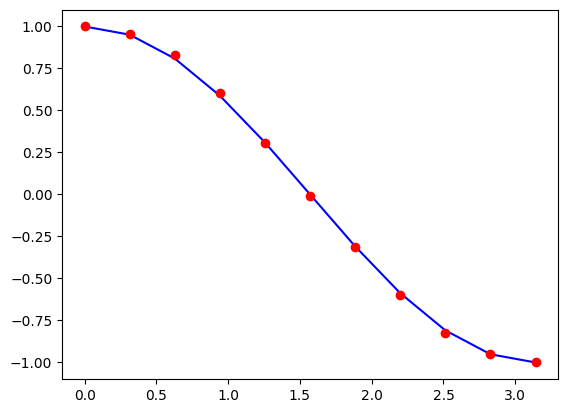

In [10]:
import matplotlib.pyplot as plt
import numpy as np

angles = [item['rx_angle'] for item in result['results'].values()]
exp_values_measured = [item['expecation_value'] for item in result['results'].values()]
exp_values_actual = np.cos(angles)

plt.plot(angles, exp_values_actual, '-', color='blue')
plt.plot(angles, exp_values_measured, 'o', color='red')
plt.draw()

## Running jobs with priority on QPUs

With Braket Jobs, you can run hybrid algorithms on all QPUs available through Amazon Braket. When you select a QPU as your device, your job will have priority access for the duration of your job. Quantum tasks created as part of your job will be executed ahead of other tasks in the device queue. This reduces the risk of certain tasks being delayed or drifting calibrations on the device. 

Before you create a hybrid job which runs tasks on a QPU, you can check how many quantum tasks or hybrid jobs are in front of you by checking device queue depth.

You can seamlessly swap the SV1 simulator for a QPU by changing the device argument in the decorator. 

When you create the job, Amazon Braket will wait for the QPU to become available before initializing the job. Note that the Braket Job will automatically select the AWS region where the device is available. As mentioned earlier, the specified device is provided to the job in the environment variable `AMZN_BRAKET_DEVICE_ARN`; the script `algorithm_script.py` uses this variable to choose the Braket device to use.

In [11]:
from braket.aws import AwsDevice
from braket.devices import Devices

# This device is used for demonstration purposes only. The actual device used for our job has been specified above.
device = AwsDevice(Devices.Rigetti.AspenM3)
print(device.queue_depth())

QueueDepthInfo(quantum_tasks={<QueueType.NORMAL: 'Normal'>: '0', <QueueType.PRIORITY: 'Priority'>: '0'}, jobs='0')


* Normal task queue depth refers to the total number of quantum tasks currently waiting to run in normal priority.
* Priority task queue depth refers to the total number of submitted quantum tasks waiting to run through Amazon Braket Hybrid Jobs. These tasks run before standalone tasks.
* Hybrid jobs queue depth refers to the total number of hybrid jobs currently queued on a device. Quantum tasks submitted as part of a hybrid job have priority, and are aggregated in the Priority Task Queue.


After you have created a hybrid job, you can track its current position within a respective device queue.

In [12]:
job.queue_position()

HybridJobQueueInfo(queue_position=None, message='Job is in COMPLETED status. AmazonBraket does not show queue position for this status.')

Jobs running task on an on-demand simulator are transitioning quickly to the `RUNNING` state. In this case, the job does not have a queue position anymore.

## Debugging with local Braket Jobs

For faster testing and debugging of your code, you can run a job locally in your own environment. This feature requires Docker to be installed in your local environment. Amazon Braket notebooks have Docker pre-installed, so you can test local jobs in hosted notebooks instantly. To install Docker in your local environment, follow these [instructions](https://docs.docker.com/get-docker/). When a local job is created for the first time, it will take longer because it needs to build the container. The subsequent runs will be faster. Note that local jobs will not be visible in the Amazon Braket Console.

To run a job in local mode, make sure the Docker daemon is running, and then simply add `local=True` to the hybrid job decorator. Local jobs run synchronously and display the logs.

In [13]:
@hybrid_job(device="arn:aws:braket:::device/quantum-simulator/amazon/sv1", local=True)
def run_local_job(n_iterations, step_size, n_shots):
    print("Execution started")
    cost_tracker = Tracker().start()

    device = AwsDevice(get_job_device_arn())
    results = run_algorithm(device, n_iterations, step_size, n_shots)

    cost_tracker.stop()
    print("Execution completed")
    return {
        "results": results,
        "task summary": cost_tracker.quantum_tasks_statistics(),
        "estimated cost": float(cost_tracker.simulator_tasks_cost() + cost_tracker.qpu_tasks_cost()),
    }


local_job = run_local_job(n_iterations=11, step_size=0.1, n_shots=1000)
print(f"{local_job.arn} {local_job.state()}")

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Pulling docker container image. This may take a while.


Login Succeeded
latest: Pulling from amazon-braket-base-jobs
762bedf4b1b7: Pulling fs layer
d2bc5ba3cab6: Pulling fs layer
c279a6f257b8: Pulling fs layer
1001faade8d4: Pulling fs layer
09248652bd77: Pulling fs layer
4602605aabf0: Pulling fs layer
af048df3b84e: Pulling fs layer
e96072c485dc: Pulling fs layer
ac0efc7b0fc7: Pulling fs layer
2e0d19604dd2: Pulling fs layer
e67318c5b12b: Pulling fs layer
e1c4c8a68602: Pulling fs layer
34ce40742040: Pulling fs layer
37464e813689: Pulling fs layer
75f03a7f135b: Pulling fs layer
07c357c800ed: Pulling fs layer
4602605aabf0: Waiting
af048df3b84e: Waiting
2e0d19604dd2: Waiting
34ce40742040: Waiting
e67318c5b12b: Waiting
e96072c485dc: Waiting
ac0efc7b0fc7: Waiting
e1c4c8a68602: Waiting
1001faade8d4: Waiting
75f03a7f135b: Waiting
37464e813689: Waiting
07c357c800ed: Waiting
c279a6f257b8: Download complete
1001faade8d4: Download complete
09248652bd77: Verifying Checksum
09248652bd77: Download complete
4602605aabf0: Download complete
762bedf4b1b7: Veri

Using the short-lived AWS credentials found in session. They might expire while running.


Boto3 Version:  1.34.96
Beginning Setup
Checking for Additional Requirements
Additional Requirements Check Finished
Running Code As Process
Execution started
Quantum circuit:
T  : │      0      │   Result Types   │
      ┌───────────┐ ┌────────────────┐ 
q0 : ─┤ Rx(theta) ├─┤ Expectation(Z) ├─
      └───────────┘ └────────────────┘ 
T  : │      0      │   Result Types   │

Unassigned parameters: [theta].
>>> Iteration 0
Metrics - timestamp=1725158625.0748582; rotation_angle=0.0; iteration_number=0;
Metrics - timestamp=1725158625.074891; expectation_value=1.0; iteration_number=0;
>>> Iteration 1
Metrics - timestamp=1725158627.9937587; rotation_angle=0.3141592653589793; iteration_number=1;
Metrics - timestamp=1725158627.993785; expectation_value=0.956; iteration_number=1;
>>> Iteration 2
Metrics - timestamp=1725158630.8331468; rotation_angle=0.6283185307179586; iteration_number=2;
Metrics - timestamp=1725158630.8331757; expectation_value=0.778; iteration_number=2;
>>> Iteration 3
Metrics

In [14]:
print("Task Summary")
print(local_job.result()['task summary'])
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run tasks in this job: {job.result()['estimated cost']} USD")

Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 11000, 'tasks': {'COMPLETED': 11}, 'execution_duration': datetime.timedelta(microseconds=187000), 'billed_execution_duration': datetime.timedelta(seconds=33)}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run tasks in this job: 0.04125 USD
